In [1]:
# ----- LIBS

# geoprocessamento
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.geometry import Point

# normalizar
import numpy as np
from shapely.geometry import mapping
from sklearn.preprocessing import MinMaxScaler

# plots
import matplotlib.pyplot as plt

# gerar e visualizar csv
import csv
import pandas as pd

# Roteiro

**O objetivo desse notebook é criar 2 datasets: o de prédios da Unicamp e o de posicionamento dos coletores no Campus.** 

Para isso, as seguintes etapas foram seguidas:

- Extração de shapes e plots da Unicamp
- Conversão de CRS
- Normalização de Mapa da Unicamp
- Remoção de prédios externos
- Tramento de Dados Faltantes
    - Buscar e Mapear prédios **!!!!**
    - Criar e ADD shapes de prédios não encontrados
    - Criar pontos não encontrados
- Criação de dataset dos Prédios da Unicamp
    - Criação de dataset (xml)
- Criação de dataset do posicionamento dos Coletores
    - Rotular Prédios 
    - ADD pontos não encontrados
    - Criação de dataset (csv)
- Salvando Mapa de prédios da Unicamp Normalizado (shapefile)
- Criando dataset de Nós - Experimentos Reais (Helder)
    - Mudar o crs dos pontos
    - Normalizar pontos
    - Criar dataset (csv)
    - Criar dataset de Mobilidade para a classe **ns3::NS2MobilityHelper** (tcl)
    

**Os datasets gerados serão utilizados como entradas para as simulações LoRaWAN feitas no simulador NS3**

**!!!!** Essa etapa do notebook foi utilizada em outras etapas do roteiro tb (ex: Remoção de prédios externos) 

# Extração de shapes e Plots da Unicamp

- Extração de região geográfica de interesse (bbbike) no formato .shp
- Plot de shapes

In [2]:
# Apontando para o path do dataset da Unicamp
import os

current_path = os.getcwd()
# print(current_path)
# print(current_path.find('obstacle_exp'))
# print(current_path[0:current_path.find('obstacle_exp')])

map_dataset_path = current_path[:current_path.find('obstacle_exp')]
building_shp_path = "datasets/unicamp-osm-dataset/shape/buildings.shp"
roads_shp_path = "datasets/unicamp-osm-dataset/shape/roads.shp"

unicamp_building_dataset_path = map_dataset_path + building_shp_path
unicamp_roads_dataset_path = map_dataset_path + roads_shp_path

In [3]:
# ----- READ BUILDING SHAPES DATASET

# use bbbike to obtain shape files
# bbbike: https://extract.bbbike.org/

# Unicamp Shapes:
# landuse
# natural
# places
# points
# railways
# roads
# waterways
# buildings

unicamp_df = gpd.read_file(unicamp_building_dataset_path)
unicamp_roads_df = gpd.read_file(unicamp_roads_dataset_path)

print('shape:', unicamp_df.shape)
unicamp_df.head()

shape: (509, 4)


,osm_id,name,type,geometry
0,95011154,IC 3,university,"POLYGON ((-47.06377 -22.81368, -47.06375 -22.8..."
1,95011157,Banco Santander,bank,"POLYGON ((-47.06880 -22.81689, -47.06881 -22.8..."
2,95011161,Ciclo Básico II,university,"POLYGON ((-47.07069 -22.81797, -47.07050 -22.8..."
3,95011169,IC - Instituto de Computação,university,"POLYGON ((-47.06520 -22.81481, -47.06452 -22.8..."
4,95011172,IC 3.5,university,"POLYGON ((-47.06422 -22.81356, -47.06417 -22.8..."


In [ ]:
# ----- CHECK BUILDING SHAPES DATASET CRS

# crs - sistema referência de coordenadas

# WGS 84 - sistema de coords mundial (degree)
unicamp_df.crs

In [ ]:
# ----- Plot UNICAMP MAPA (WGS84)
ax = unicamp_df.plot(figsize=(15, 7))
unicamp_roads_df.plot(ax=ax, figsize=(15, 7), color='gray')

In [ ]:
# ----- PLOT IC BUILDING (WGS84)
ic_predio = unicamp_df.query('osm_id == 95011169')
ax = ic_predio.plot()
ic_predio.head()

# Conversão de CRS

Conversão de CRS WGS 84 para SIRGAS 2000 / UTM zone 23S , que é dado em metros e representa o sistemas de georeferência das Américas.

Características:

- Datum: SIRGAS 2000
- Projeção: UTM zone 23S (Campinas/SP)
- América Latina
- Hemisfério sul. 

Referências:
- https://epsg.io/31981
- https://spatialreference.org/ref/?search=31981
- https://pt.slideshare.net/JorgeSantos30/20141011-qgis24-sistemadereferenciadecoordenadas
- https://ocefpaf.github.io/python4oceanographers/blog/2013/12/16/utm/
- https://cursos.alura.com.br/forum/topico-erro-ao-reprojetar-usando-a-funcao-to_crs-77139


In [4]:
# Geodataframe dos Prédios da Unicamp
unicamp_df = gpd.read_file(unicamp_building_dataset_path)
unicamp_df.head(10)

,osm_id,name,type,geometry
0,95011154,IC 3,university,"POLYGON ((-47.06377 -22.81368, -47.06375 -22.8..."
1,95011157,Banco Santander,bank,"POLYGON ((-47.06880 -22.81689, -47.06881 -22.8..."
2,95011161,Ciclo Básico II,university,"POLYGON ((-47.07069 -22.81797, -47.07050 -22.8..."
3,95011169,IC - Instituto de Computação,university,"POLYGON ((-47.06520 -22.81481, -47.06452 -22.8..."
4,95011172,IC 3.5,university,"POLYGON ((-47.06422 -22.81356, -47.06417 -22.8..."
5,95011175,DAC - Diretoria Acadêmica do Campus,university,"POLYGON ((-47.07073 -22.81754, -47.07051 -22.8..."
6,95463718,Restaurante Universitário,restaurant,"POLYGON ((-47.07236 -22.81793, -47.07183 -22.8..."
7,95463720,GMU - Ginásio Multidisciplinar,university,"POLYGON ((-47.07183 -22.81502, -47.07153 -22.8..."
8,95463721,None,None,"POLYGON ((-47.06819 -22.81501, -47.06789 -22.8..."
9,95463722,Instituto de Filosofia e Ciencias Humanas,university,"POLYGON ((-47.06806 -22.81536, -47.06853 -22.8..."


In [5]:
# Conversão de WSG84 para SIRGAS 2000 / UTM one 23S : 31983
# Zona 23 inclui Campinas
# https://spatialreference.org/ref/epsg/31983/

unicamp_utm_df = unicamp_df.to_crs(31983)
unicamp_utm_df.crs

<Projected CRS: EPSG:31983>
Name: SIRGAS 2000 / UTM zone 23S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Brazil - 48°W to 42°W
- bounds: (-48.0, -33.5, -42.0, 5.13)
Coordinate Operation:
- name: UTM zone 23S
- method: Transverse Mercator
Datum: Sistema de Referencia Geocentrico para las AmericaS 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
# Plot de mapa Convertido para SIRGAS 2000 / UTM zone 23S
ax = unicamp_utm_df.plot()
plt.title('Unicamp xy (m)',fontweight='bold',fontsize=14)

# Dataframe convertido
unicamp_utm_df.head(10)

In [6]:
unicamp_utm_df['centroids'] = unicamp_utm_df.centroid
unicamp_utm_df['centroids']

0      POINT (288164.757 7475614.484)
1      POINT (287680.703 7475257.946)
2      POINT (287463.109 7475182.762)
3      POINT (288079.758 7475493.426)
4      POINT (288158.099 7475640.063)
                    ...              
504    POINT (288473.227 7474421.359)
505    POINT (288491.927 7474443.209)
506    POINT (286688.852 7474451.339)
507    POINT (286696.551 7474453.636)
508    POINT (289447.856 7473449.118)
Name: centroids, Length: 509, dtype: geometry

In [ ]:
unicamp_utm_df.head()

# Normalização de Mapa da Unicamp

In [7]:
# Bounds of Unicamp Map
unicamp_minx, unicamp_miny, unicamp_maxx, unicamp_maxy = unicamp_utm_df.geometry.total_bounds

print('bounds:', unicamp_minx, unicamp_miny, unicamp_maxx, unicamp_maxy)
print('x:', unicamp_maxx-unicamp_minx)
print('y:', unicamp_maxy- unicamp_miny)


bounds: 285960.71918678837 7473387.272237044 290348.567447891 7476048.738107968
x: 4387.848261102627
y: 2661.465870924294


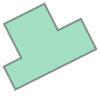

In [8]:
# get all geometries of unicamp_utm_df
unicamp_geometries = [i for i in unicamp_utm_df.geometry]

# geometry example
unicamp_geometries[0]

In [9]:
map_minx = 1e+10
map_maxx = -1
map_miny = 1e+10
map_maxy = -1

for geometry in range(len(unicamp_geometries)):
    
    # get all coordinates (x,y) of polygons in unicamp_utm_df
    all_coords_per_geometry = mapping(unicamp_geometries[geometry])["coordinates"] 

    # split all coordinates per geometry and get x coords and y coords
    x_coords = [all_coords_per_geometry[0][i][0] for i in range(len(all_coords_per_geometry[0]))]
    y_coords = [all_coords_per_geometry[0][i][1] for i in range(len(all_coords_per_geometry[0]))]
    
    # convert to 2D array
    x_coords = np.array(x_coords)
    y_coords = np.array(y_coords)
    
    # get all geometry coords in x and y
    if geometry == 0:
        all_coords_x = x_coords.copy()
        all_coords_y = y_coords.copy()
    else:
        all_coords_x = np.append (all_coords_x, x_coords.copy(), axis=0)
        all_coords_y = np.append (all_coords_y, y_coords.copy(), axis=0)
        
    # get bounds limits of map and compare with unicamp_utm_df.geometry.total_bounds
    # after for loop, limits must be equal
    if np.min(x_coords) < map_minx:
        map_minx = np.min(x_coords)
    if np.max(x_coords) > map_maxx:
        map_maxx = np.max(x_coords)
    
    if np.min(y_coords) < map_miny:
        map_miny = np.min(y_coords)
    if np.max(y_coords) > map_maxy:
        map_maxy = np.max(y_coords)
    

# after for loop, limits must be equal
print(map_minx, map_miny,map_maxx, map_maxy)
print(unicamp_minx, unicamp_miny, unicamp_maxx, unicamp_maxy)
# yey

# convert to 2D array 
x = np.array(all_coords_x).reshape(-1, 1) # reshape -> 2D array
y = np.array(all_coords_y).reshape(-1, 1)

285960.71918678837 7473387.272237044 290348.567447891 7476048.738107968
285960.71918678837 7473387.272237044 290348.567447891 7476048.738107968


In [10]:
# create a normalized map with unicamp bounds

# criando novo mapa, que conterá geometrias normalizadas
mapa_normalizado = gpd.GeoDataFrame(columns=["geometry"])
mapa_normalizado['osm_id'] = unicamp_utm_df['osm_id']
mapa_normalizado['name'] = unicamp_utm_df['name']
mapa_normalizado['type'] = unicamp_utm_df['type']

# processo de normalização
for geometry in range(len(unicamp_geometries)):

    # get all coordinates (x,y) of polygons in unicamp_utm_df
    all_coords_per_geometry = mapping(unicamp_geometries[geometry])["coordinates"] 
    
    # split all coordinates per geometry and get x coords and y coords
    x_coords = [all_coords_per_geometry[0][i][0] for i in range(len(all_coords_per_geometry[0]))]
    y_coords = [all_coords_per_geometry[0][i][1] for i in range(len(all_coords_per_geometry[0]))]
    
    # convert to 2D array
    x_coords = np.array(x_coords).reshape(-1, 1) 
    y_coords = np.array(y_coords).reshape(-1, 1)
    
    # define limits of normalization
    scaler_x = MinMaxScaler(feature_range = (0, unicamp_maxx - unicamp_minx))
    scaler_y = MinMaxScaler(feature_range = (0, unicamp_maxy - unicamp_miny))
    
    # normalize with all all geometry coords x 
    scaler_x.fit(x)
    transform_x = scaler_x.transform(x_coords)
    
    # normalize with all all geometry coords y
    scaler_y.fit(y)
    transform_y = scaler_y.transform(y_coords)
    
    # convert np array x and y normalized back to polygon
    building_geometry = np.append (transform_x, transform_y, axis=1)
    new_polygon = Polygon(building_geometry)
    
    mapa_normalizado.loc[geometry, 'geometry'] = new_polygon
    

print('Shape do Mapa normalizado:', mapa_normalizado.shape)
mapa_normalizado.head()

Shape do Mapa normalizado: (509, 4)


,geometry,osm_id,name,type
0,"POLYGON ((2219.251 2238.728, 2221.362 2239.787...",95011154,IC 3,university
1,"POLYGON ((1707.932 1875.916, 1706.879 1871.880...",95011157,Banco Santander,bank
2,"POLYGON ((1515.427 1753.464, 1534.537 1769.617...",95011161,Ciclo Básico II,university
3,"POLYGON ((2073.981 2111.450, 2144.257 2142.551...",95011169,IC - Instituto de Computação,university
4,"POLYGON ((2173.354 2250.869, 2178.317 2240.382...",95011172,IC 3.5,university


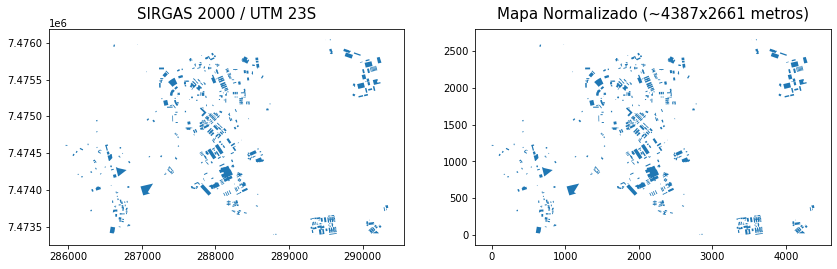

In [11]:
# ANTES E DEPOIS DA NORMALIZAÇÃO

fig, axes = plt.subplots(1,2, figsize = (14, 7)) # 1 linha, 2 colunas

# Mapa da unicamp no crs SIRGAS 2000/ UTM 23S
axes[0].set_title('SIRGAS 2000 / UTM 23S', fontsize=15, y=1.02)
unicamp_utm_df.plot(ax=axes[0])

# Mapa da Unicamp
# onde:
# - unicamp bounds = 285960.71918678837 7473387.272237044 290348.567447891 7476048.738107968
# - maxx - minx    = 4387.848261102627
# - maxy - miny    = 2661.465870924294
axes[1].set_title('Mapa Normalizado (~4387x2661 metros)', fontsize=15, y=1.02)
mapa_normalizado.plot(ax=axes[1])

plt.show()

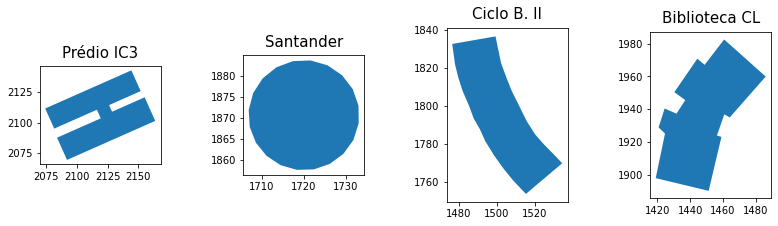

In [12]:
# EXEMPLO DE PRÉDIOS NORMALIZADOS

# get buildings
ic_predio = mapa_normalizado.query('osm_id == 95011169')
santander = mapa_normalizado.query('osm_id == 95011157')
cbII_predio = mapa_normalizado.query('osm_id == 95011161')
biblioteca = mapa_normalizado.query('osm_id == 95463723')

# plot buildings
fig, axes = plt.subplots(1,4, figsize = (12, 5)) # 2 linha, 2 colunas

# Mapa da unicamp no crs SIRGAS 2000/ UTM 23S
axes[0].set_title('Prédio IC3', fontsize=15, y=1.02)
ic_predio.plot(ax=axes[0])

axes[1].set_title('Santander', fontsize=15, y=1.02)
santander.plot(ax=axes[1])

axes[2].set_title('Ciclo B. II', fontsize=15, y=1.02)
cbII_predio.plot(ax=axes[2])

axes[3].set_title('Biblioteca CL', fontsize=15, y=1.02)
biblioteca.plot(ax=axes[3])

# space between subplots
fig.tight_layout(pad=5.0)

plt.show()

# Google Maps: https://www.google.com/maps/place/Coordenadoria+de+P%C3%B3s-gradua%C3%A7%C3%A3o+-+Instituto+de+Biologia+%2F+Unicamp/@-22.8174874,-47.069779,253m/data=!3m1!1e3!4m5!3m4!1s0x0:0x5970884374643347!8m2!3d-22.8194777!4d-47.0698417

# Remove Prédios externos ao Campus

In [ ]:
mapa_normalizado.head(5)

In [ ]:
# filter row by osm_id
# mapa_normalizado[mapa_normalizado['osm_id'] == 95011157]

mapa_normalizado.plot(figsize=(12,5))

In [13]:
# REMOVE PRÉDIOS EXTERNOS A UNICAMP
predios_externos = [
430669816, 430669831, 430669834, 432450447, 433093651, 433113382, 433113491, 433113680, 433122921,
365923638, 365923673, 365923778, 365923845, 365923888, 152072898, 152073614, 152073616, 152073618,
152073619, 260542749, 186578257, 186578259, 258633062, 365923609, 355176010, 256659533, 355176008,
365923625, 365923635, 404611803, 404611804, 404611805, 404611806, 404611807, 404611808, 404718313,
404727748, 404727750, 430268890, 430268891, 430268893, 430268896, 430268898, 433123132, 433124150,
433124151, 433124152, 433124153, 433124154, 433124155, 433124207, 535296300, 535296301, 535296302,
535297665, 531269652, 535297666, 535297667, 535297668, 535297669, 535300979, 535300980, 535300981,
535300982, 535300983, 535300984, 535300985, 535300986, 535300987, 535313329, 535313331, 535313333,
535313335, 535313337, 535313338, 535313340, 535313342, 535313344, 535313346, 535313348, 535313350,
535324162, 535324164, 535324165, 535324163, 535324166, 535324167, 535324168, 535324169, 535324170,
535324171, 535324172, 535324173, 535324174, 535324175, 535324176, 535324177, 535324178, 535324179,
535324180, 535324181, 535324182, 535324183, 535324185, 535324186, 535324187, 535324188, 535324189,
535335892, 535335894, 535335895, 535335897, 535300988, 535335899, 535300988, 535335899, 535335900, 
535335901, 535354595, 535354596, 535335898, 535324184, 535305960, 531269049, 538743968, 538971320,
538971329, 539206917, 539211849, 539409502, 539409503, 539622003, 540438600, 540438602, 540438604, 
541342109, 556029153, 556460922, 556460927, 556460929, 556460931, 556460933, 556460935, 556460937,
556460939, 556460943, 556460944, 556460947, 556460948, 563505750, 564166303, 566854866, 566854867,
603144340, 603150725, 603150726, 626214630, 626214631, 627167444, 627167446, 627167447, 627663595,
627663596, 627663597, 627167444, 627167446, 627167447, 627663595, 627663596, 627663597, 627663598,
627798928, 627798929, 627798931, 627798933, 627798936, 627798938, 627802134, 627802135, 633390066,
633390068, 633390069, 633390071, 633390072, 633390073, 633390074, 633390075, 633390076, 633390077,
633390078, 633390079, 633390080, 633390082, 633390083, 633390084, 633390087, 633390089, 633390094,
633390096, 633390098, 633390101, 633390104, 633390105, 633390106, 633390108, 633390109, 633390110,
633390111, 633390112, 684602338, 684602339, 684602340, 694483210, 694483211, 747442134, 747442133,
792139327, 556460920, 556460945, 556460946, 556327607, 556327608
]

for predio in predios_externos:
    mapa_normalizado.drop(mapa_normalizado.index[mapa_normalizado['osm_id'] == predio], inplace = True)

# reorganizando indexes
mapa_normalizado = mapa_normalizado.reset_index(drop=True)
mapa_normalizado.head()

,geometry,osm_id,name,type
0,"POLYGON ((2219.251 2238.728, 2221.362 2239.787...",95011154,IC 3,university
1,"POLYGON ((1707.932 1875.916, 1706.879 1871.880...",95011157,Banco Santander,bank
2,"POLYGON ((1515.427 1753.464, 1534.537 1769.617...",95011161,Ciclo Básico II,university
3,"POLYGON ((2073.981 2111.450, 2144.257 2142.551...",95011169,IC - Instituto de Computação,university
4,"POLYGON ((2173.354 2250.869, 2178.317 2240.382...",95011172,IC 3.5,university


<AxesSubplot:>

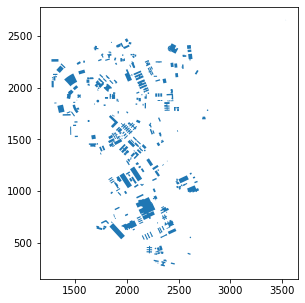

In [14]:
mapa_normalizado.plot(figsize=(12,5))

In [ ]:
mapa_normalizado.shape

In [ ]:
mapa_normalizado.head(mapa_normalizado.shape[0])

# Tratamento de Dados Faltantes

- **[OK]** Museu
- **[OK]** IG (parte superior do mapa)
- **[OK]** IG (parte inferior do mapa)
- **[OK]** Centro de Biologia Molecular e Engenharia Genética (CBMEG) 
- **[OK]** Centro de Computação (CCUEC) 
- **[OK]** Ciclo Básico I 
- **[OK]** Escola Estadual de Ensino Fundamental Físico Sérgio Pereira Porto (SERGIO PORTO)
- **[OK]** Grupo Gestor de Obras (GGO) 
- **[OK]** Ponto de ônibus – Rua Roxo Moreira (PO-RM)
- **[OK]** Ponto de ônibus – Avenida Adolpho Lutz (PO-AL)
- **[OK]** Ponto de ônibus – Rua Vital Brasil (PO-VB)

In [ ]:
# Some useful functions

from shapely.geometry import Point
from shapely.geometry import box


ref_osm_id = int(10000000)
def add_dataset_rows(geodataset, new_polygon, name, type_building ):
    global ref_osm_id
    last_index = geodataset.shape[0]
    geodataset.loc[last_index, 'geometry'] = new_polygon
    geodataset.loc[last_index, 'osm_id'] = ref_osm_id
    geodataset.loc[last_index, 'name'] = name
    geodataset.loc[last_index, 'type'] = type_building
    ref_osm_id = int(ref_osm_id + 1)
    print("Novo Shape:", geodataset.shape)
    
    return geodataset.iloc[geodataset.shape[0]-1:geodataset.shape[0]]


def add_node_dataset_rows(geodataset, name, type_building, point):
    global ref_osm_id
    last_index = geodataset.shape[0]
    geodataset.loc[last_index, 'osm_id'] = ref_osm_id
    geodataset.loc[last_index, 'name'] = name
    geodataset.loc[last_index, 'type'] = type_building
    geodataset.loc[last_index, 'x'] = point.x
    geodataset.loc[last_index, 'y'] = point.y
    geodataset.loc[last_index, 'z'] = 1.5
    
    ref_osm_id = int(ref_osm_id + 1)
    print("Novo Shape:", geodataset.shape)
    
    return geodataset.iloc[geodataset.shape[0]-1:geodataset.shape[0]]

def get_polygon_coords (polygon):
    g = [i for i in polygon.geometry]
    x,y = g[0].exterior.coords.xy
    coords = np.dstack((x,y)).tolist()
    
    return coords


def create_circle_building(x, y, buffer):
    circle = Point(x, y).buffer(buffer) 

    print("Area:", circle.area)
    print("Length:", circle.length)
    
    return circle

def create_box_building(building_name, bounds, offset_xmin, offset_ymin, offset_xmax, offset_ymax):
    new_building = box(
        bounds[0] - offset_xmin,
        bounds[1] - offset_ymin,
        bounds[2] -offset_xmax,
        bounds[3] -offset_ymax
    )

    print("Bounds do prédio " + str(building_name) + ":", bounds)
    print("\nÁrea:", new_building.area)
    print("Length:", new_building.length)
    
    return new_building


def compare_buildings(ref_building, new_building):
    geodataset_ref = gpd.GeoSeries(ref_building)
    ax = geodataset_ref.plot(color='Gray')

    geodataset_new = gpd.GeoSeries(new_building)
    geodataset_new.plot(ax=ax) 

    
def calculate_distance(osm_id, new_polygon):
    # ----- Criação de Geodataframe para o calculo de distancia entre centroids do Museu e predio de referência (Inova)
    points_df = gpd.GeoDataFrame(columns=["geometry"])
    points_df.loc[:, 'geometry'] = mapa_normalizado.query('osm_id ==' + str(osm_id))['geometry']
    points_df.loc[0, 'geometry'] = new_polygon

    points_df['centroid'] = points_df["geometry"].centroid

    # Cálculo de Distância entre Circle centroids e cada linha do dataset
    print("Distancia entre centroids:\n", points_df.distance(new_polygon.centroid))

    return points_df

## Buscar e Mapear predios

In [ ]:
# ----- RESULTADOS DO MAPEAMENTO (prédios com coletores)

# ENCONTRADOS POR CONSULTA DE NOME:
# 1. Agência de Inovação Inova Unicamp (INOVA) # 163762428
# 2. Biblioteca Central (BC) # 95463723
# 11. Ciclo Básico II # 95011161
# 14. Diretoria Geral de Recursos Humanos (DGRH) # 362643631
# 18. Faculdade de Ciências Médicas (FCM) # 537142892
# 24. Faculdade de Engenharia Elétrica e de Computação (FEEC) # 269851018
# 25. Faculdade de Engenharia Mecânica (FEM) # 554951124
# 27. Fundação de Desenvolvimento da Unicamp (FUNCAMP) # 556327623
# 32. Instituto de Biologia (IB) # 95540601
# 33. Instituto de Computação (IC) # 95011169
# 35. Instituto de Filosofia e Ciências Humanas (IFCH) # 95463722
# 39. Instituto de Matemática, Estatística e Computação Científica (IMECC) # 95463724
# 41. Prefeitura Universitária # 562047775
# 45. Restaurante Administrativo (RA) # 269851019
# 46. Restaurante Saturnino (RS) # 270488633
# 47. Restaurante Universitário (RU) # 95463718


# ENCONTRADOS POR CONSULTA DE TIPO:

# 4. Centro de Componentes Semicondutores (CCS) # 554951142
# 6. Centro de Diagnóstico de Doenças do Aparelho Digestivo (GASTROCENTRO) # 556327645 e 556327646
# 8. Centro de Hematologia e Hemoterapia (HEMOCENTRO) # 556327636
# 9. Centro para Manutenção de Equipamentos (CEMEQ) # 556327686
# 12. Coordenadoria de Desenvolvimento Cultural (CDC) # 95463720
# 13. Diretoria Geral da Administração (DGA) # 554951141
# 15. Divisão de Educação Infantil e Complementar (DEdIC) # 537155702
# 16. Engenharia Básica (EB)  # 554951142 (ccs)
# 20. Faculdade de Enfermagem (FEnf) # 537142893
# 21. Faculdade de Engenharia Agrícola (FEAGRI) # 97592693 ~
# 23. Faculdade de Engenharia de Alimentos (FEA) # 554951120 ~
# 26. Faculdade de Engenharia Química (FEQ) # 554968138
# 28. Gabinete do Reitor (GR) # 562047779
# 34. Instituto de Estudos da Linguagem (IEL) # 556327698 ~
# 40. Instituto de Química (IQ) # 96493946


# ENCONTRADOS POR SHAPES:

# 7. Centro de Estudos de Petróleo (CEPETRO) 562047735
# 19. Faculdade de Educação Física (FEF) # 96446654
# 22. Faculdade de Engenharia Civil, Arquitetura e Urbanismo (FEC) # 556327678
# 30. Hospital de Clínicas (HC) # 538334949
# 31. Instituto de Artes (IA) # 537166697
# 36. Instituto de Física Gleb Wataghin (IFGW) # 556327703
# 38. Instituto de Geociências (IG) da Avenida Érico Veríssimo (superior)-------------


# NÃO ESTÃO NO MAPA (DADOS FALTANTES - 9):

# 3. Centro de Biologia Molecular e Engenharia Genética (CBMEG) 
# 5. Centro de Computação (CCUEC) 
# 10. Ciclo Básico I 
# 17. Escola Estadual de Ensino Fundamental Físico Sérgio Pereira Porto (SERGIO PORTO)
# 29. Grupo Gestor de Obras (GGO) 
# 37. Instituto de Geociências (IG) da Rua Oswaldo Cruz (inferior) 

# Casos especiais:
# 42. Ponto de ônibus – Rua Roxo Moreira (PO-RM)
# 43. Ponto de ônibus – Avenida Adolpho Lutz (PO-AL)
# 44. Ponto de ônibus – Rua Vital Brasil (PO-VB)

In [ ]:
# ----- METÓDOS DE BUSCA PARA MAPEAMENTO

# Busca por linha em todo dataset
predio = mapa_normalizado.iloc[1:2] #ex Reitoria 367-376
print(mapa_normalizado.shape)
predio.head(predio.shape[0])

# Busca por Nome
# predio = mapa_normalizado[mapa_normalizado['name'].str.contains("Restaurante",  na=False)]
# predio.head()

# Busca de todos os predios com Nome None
# predio_sem_indentificacao = mapa_normalizado[mapa_normalizado['name'].isna()]
# predio = predio_sem_indentificacao
# predio.head()

# Busca por linhas de todos os predios com Nome None
# predio_sem_indentificacao = mapa_normalizado[mapa_normalizado['name'].isna()]
# predio = predio_sem_indentificacao.iloc[47:48] # ex HC
# predio.head()

In [ ]:
# predio.plot(color="red")

In [ ]:
### ----- PLOT DE PREDIO DE ACORDO COM A BUSCA REALIZADA

ax = mapa_normalizado.plot(figsize=(12, 5))

# predios None
predio['geometry'].plot(ax=ax, color='Red')

# Para ampliar area mudar param. de set_xlim e set_ylim
minx, miny, maxx, maxy = mapa_normalizado.total_bounds
ax.set_xlim(minx -100, maxx)
ax.set_ylim(miny -100, maxy)

## Cria e ADD shapes de prédios não encontrados

### Museu

In [ ]:
# ----- CRIANDO SHAPE DO MUSEU
ref_id = 386834061
circle = create_circle_building(2873, 2125, 16.45)
circle

In [ ]:
# -----PLOT DE MAPA NORMALIZADO E SHAPE DO MUSEU

ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))
circle_df = gpd.GeoDataFrame(columns=["geometry"])
circle_df.loc[0, 'geometry'] = circle
circle_df.plot(ax=ax, color="black")

# para ampliar area mudar param. de set_xlim e set_ylim
minx, miny, maxx, maxy = mapa_normalizado.total_bounds
ax.set_xlim(2650, 3000)
ax.set_ylim(2050, 2200)

In [ ]:
calculate_distance(ref_id, circle)

In [ ]:
add_dataset_rows(mapa_normalizado, circle, 'Museu Exploratório', 'university')

### IG (parte superior) 

In [ ]:
ref_id = 556327663
ref_polygon = mapa_normalizado.query('osm_id ==' + str(ref_id))
print(ref_polygon['geometry'].centroid)

# Get Polygon value
# get_polygon_coords(ref_polygon)

building_IG = box(1628, 2289.589499125257, 1748,2323.997095678933)

print("\nArea:", building_IG.area)
print("Length:",building_IG.length)
building_IG.boundary

In [ ]:
compare_buildings(ref_polygon['geometry'].boundary, building_IG )

In [ ]:
ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))
# teste = gpd.GeoSeries(building_IG.boundary)
teste = gpd.GeoSeries(building_IG)
teste.plot(ax=ax) 

# para ampliar area mudar param. de set_xlim e set_ylim
minx, miny, maxx, maxy = mapa_normalizado.total_bounds
ax.set_xlim(1000, 2500)
ax.set_ylim(2000, maxy)

In [ ]:
add_dataset_rows(mapa_normalizado, building_IG, 'IG-cima', 'university')

In [ ]:
mapa_normalizado.shape

### CCUEC

In [ ]:
ref_id = 146276265
ref_polygon = mapa_normalizado.query('osm_id ==' + str(ref_id))

# Get Polygon value
# get_polygon_coords(ref_polygon)

In [ ]:
bounds_ref = list(ref_polygon.geometry.total_bounds)
building_CUEC = create_box_building("CCUEC", bounds_ref, 90, 0, 70, 10)
building_CUEC.boundary

In [ ]:
compare_buildings(ref_polygon['geometry'].boundary, building_CUEC )

In [ ]:
ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))

teste = gpd.GeoSeries(building_CUEC)
teste.plot(ax=ax) 

# para ampliar area mudar param. de set_xlim e set_ylim
minx, miny, maxx, maxy = mapa_normalizado.total_bounds
ax.set_xlim(1500, 2600)
ax.set_ylim(1400, 2200)

In [ ]:
add_dataset_rows(mapa_normalizado, building_CUEC, 'CCUEC', 'university')

### CBMEG

In [ ]:
# Prédio Ref: 537243162
ref_id = 537243162
ref_polygon = mapa_normalizado.query('osm_id ==' + str(ref_id))
# get_polygon_coords(ref_polygon)

In [ ]:
bounds_ref = list(ref_polygon.geometry.total_bounds)

bounds_CBMEG = create_box_building("CBMEG", bounds_ref, 60, 120, 75 , 98)
bounds_CBMEG.boundary

In [ ]:
compare_buildings(ref_polygon['geometry'].boundary, bounds_CBMEG)

In [ ]:
calculate_distance(ref_id, bounds_CBMEG )

In [ ]:
ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))

teste = gpd.GeoSeries(bounds_CBMEG)
teste.plot(ax=ax) 

# # para ampliar area mudar param. de set_xlim e set_ylim
minx, miny, maxx, maxy = mapa_normalizado.total_bounds
ax.set_xlim(2000, 3000)
ax.set_ylim(1400, 2200)

In [ ]:
add_dataset_rows(mapa_normalizado, bounds_CBMEG, 'CBMEG', 'university')

### Ciclo Básico I

In [ ]:
ref_id = 95011157
ref_polygon = mapa_normalizado.query('osm_id ==' + str(ref_id))

circle_up = create_circle_building(ref_polygon.centroid.x, ref_polygon.centroid.y - 40, 17.85)
circle_down = create_circle_building(ref_polygon.centroid.x -10 , ref_polygon.centroid.y - 75, 17.85)
circle_up

In [ ]:
# circle_df = gpd.GeoDataFrame(columns=["geometry"])
# circle_df.loc[0, 'geometry'] = circle_up
# get_polygon_coords(circle_df)

In [ ]:
# -----PLOT DE MAPA NORMALIZADO E SHAPE DO MUSEU

ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))
circle_df = gpd.GeoDataFrame(columns=["geometry"])
circle_df.loc[0, 'geometry'] = circle_up
circle_df.loc[1, 'geometry'] = circle_down
circle_df.plot(ax=ax, color="black")

# para ampliar area mudar param. de set_xlim e set_ylim
minx, miny, maxx, maxy = mapa_normalizado.total_bounds
ax.set_xlim(1675, 1775)
ax.set_ylim(1750, 1875)

In [ ]:
calculate_distance(ref_id, circle_up)

In [ ]:
add_dataset_rows(mapa_normalizado, circle_up, 'CBI', 'university')

### SERGIO PORTO

In [ ]:
# Prédio Ref: 537155703
ref_id = 537155703
ref_polygon = mapa_normalizado.query('osm_id ==' + str(ref_id))
# get_polygon_coords(ref_polygon)

In [ ]:
bounds_ref = list(ref_polygon.geometry.total_bounds)

building_SP = create_box_building("SPorto", bounds_ref, -160, -25, -100 , -30)
building_SP.boundary

In [ ]:
compare_buildings(ref_polygon['geometry'].boundary, building_SP)

In [ ]:
calculate_distance(ref_id, building_SP )

In [ ]:
ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))

teste = gpd.GeoSeries(building_SP)
teste.plot(ax=ax) 

# # para ampliar area mudar param. de set_xlim e set_ylim
minx, miny, maxx, maxy = mapa_normalizado.total_bounds
ax.set_xlim(2000, 3000)
ax.set_ylim(500, 1000)

In [ ]:
add_dataset_rows(mapa_normalizado, building_SP, 'Sergio Porto', 'school')

### GGOBRAS

In [ ]:
# Prédio Ref: 554951137
ref_id = 554951137
ref_polygon = mapa_normalizado.query('osm_id ==' + str(ref_id))
# get_polygon_coords(ref_polygon)

In [ ]:
bounds_ref = list(ref_polygon.geometry.total_bounds)

building_GGO = create_box_building("GGO", bounds_ref, 75, -20, 85 , -20)
building_GGO.boundary

In [ ]:
compare_buildings(ref_polygon['geometry'].boundary, building_GGO)

In [ ]:
calculate_distance(ref_id, building_GGO )

In [ ]:
ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))

teste = gpd.GeoSeries(building_GGO)
teste.plot(ax=ax) 

# # para ampliar area mudar param. de set_xlim e set_ylim
minx, miny, maxx, maxy = mapa_normalizado.total_bounds
ax.set_xlim(1500, 2400)
ax.set_ylim(1000, 1500)

In [ ]:
add_dataset_rows(mapa_normalizado, building_GGO, 'GGO', 'university')

## Cria e ADD Pontos não encontrados

### IG (parte inferior) e EB

In [ ]:
# Tratamento para que prédio do IG e EB não tenham o mesmo centroid do prédio com o ID 554951142

ref_id = 554951142
point_IG = mapa_normalizado.query('osm_id ==' + str(ref_id))
print(point_IG['geometry'].centroid)

# Get Polygon value
# get_polygon_coords(point_IG)

In [ ]:
# Reposicionando posicionamento do IG e EB (ao inves de centroid do prédio)
pt_IG = Point(2110, 1110)
pt_EB = Point(2060, 1210)

# Plot de paradas de ÔNIBUS
pt_IG_df = gpd.GeoDataFrame(columns=["geometry"],  crs='EPSG:31983')
pt_IG_df.loc[0, 'geometry'] = pt_IG
pt_IG_df.loc[1, 'geometry'] = Point (2089.558, 1166.068) # point_IG['geometry'].centroid
pt_IG_df.loc[2, 'geometry'] = pt_EB

ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))
pt_IG_df.plot(ax=ax, color="black")

# para ampliar area mudar param. de set_xlim e set_ylim
minx, miny, maxx, maxy = mapa_normalizado.total_bounds
ax.set_xlim(1500, 3000)
ax.set_ylim(1000, 1500)

### Paradas de Ônibus

In [ ]:
# Coordenadas obtidas pelo notebook "Mapa dinâmico"
# Google Maps ajuda nessa parte tb

parada_RM = Point(-47.0677, -22.8242) 
parada_AL = Point(-47.0629, -22.8319) 
parada_VB = Point(-47.0628, -22.8275)

# Convertendo Coordenadas em Degree para metros (31983)
pontos_onibus_df = gpd.GeoDataFrame(columns=["geometry"],  crs='EPSG:4326')
pontos_onibus_df.loc[0, 'geometry'] = parada_RM
pontos_onibus_df.loc[1, 'geometry'] = parada_AL
pontos_onibus_df.loc[2, 'geometry'] = parada_VB
pontos_onibus_df = pontos_onibus_df.to_crs('EPSG:31983')
# pontos_onibus_df.crs
pontos_onibus_df

In [ ]:
# PONTOS no CRS EPSG:31983
parada_RM = Point(pontos_onibus_df['geometry'][0])
parada_AL = Point(pontos_onibus_df['geometry'][1])
parada_VB = Point(pontos_onibus_df['geometry'][2])

print(parada_RM)
print(parada_AL)
print(parada_VB)

In [ ]:
# NORMALIZAÇÃO DE PONTOS 

points = [parada_RM, parada_AL, parada_VB]
norm_points = []

# convert to 2D array 
x = np.array(all_coords_x).reshape(-1, 1) # reshape -> 2D array
y = np.array(all_coords_y).reshape(-1, 1)

for coords in points:
    # convert to 2D array
    x_coords = np.array([coords.x]).reshape(-1, 1)
    y_coords = np.array([coords.y]).reshape(-1, 1)

    # define limits of normalization
    scaler_x = MinMaxScaler(feature_range = (0, unicamp_maxx - unicamp_minx))
    scaler_y = MinMaxScaler(feature_range = (0, unicamp_maxy - unicamp_miny))

    # normalize with all all geometry coords x 
    scaler_x.fit(x)
    transform_x = scaler_x.transform(x_coords)

    # normalize with all all geometry coords y
    scaler_y.fit(y)
    transform_y = scaler_y.transform(y_coords)

    print(transform_x, transform_y)
    norm_points.append(Point(transform_x, transform_y))

print(norm_points[0])

In [ ]:
# p/ Plotar paradas de ÔNIBUS
pontos_onibus_norm_df = gpd.GeoDataFrame(columns=["geometry"],  crs='EPSG:31983')
pontos_onibus_norm_df.loc[0, 'geometry'] = norm_points[0]
pontos_onibus_norm_df.loc[1, 'geometry'] = norm_points[1]
pontos_onibus_norm_df.loc[2, 'geometry'] = norm_points[2]

pontos_onibus_norm_df

In [ ]:
# Plot de paradas de ÔNIBUS
ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))
pontos_onibus_norm_df.plot(ax=ax, color="black")

In [ ]:
a =  mapa_normalizado.iloc[mapa_normalizado.shape[0]-10: mapa_normalizado.shape[0]]
a

# Criação de dataset dos Prédios da Unicamp

- Create a xml file with Unicamp Building shapes & height
- The outuput xml file will serve as input of NS3

In [ ]:
# estudando e tratando a string Polygon
polygon_str = str(mapa_normalizado['geometry'][0])
polygon_coords = polygon_str[polygon_str.find("(") + 2:]
polygon_coords = polygon_coords[ : polygon_coords.find(")")]
polygon_coords

In [ ]:
# Criando xml dataset
from xml.dom import minidom
import os 
  
root = minidom.Document()
  
xml = root.createElement('additional') 
xml.setAttribute('xmlns:xsi','http://www.w3.org/2001/XMLSchema-instance')
xml.setAttribute('xsi:noNamespaceSchemaLocation','http://sumo.dlr.de/xsd/additional_file.xsd')
root.appendChild(xml)

for i in range(len(mapa_normalizado['geometry'])):   
    
    polygon_str = str(mapa_normalizado['geometry'][i])
    polygon_coords = polygon_str[polygon_str.find("(") + 2:]
    polygon_coords = polygon_coords[ : polygon_coords.find(")")]
    
    productChild = root.createElement('poly')
    productChild.setAttribute('id', str(mapa_normalizado['osm_id'][i]))
    productChild.setAttribute('type', str(mapa_normalizado['type'][i]))
    productChild.setAttribute('color', '255.0,230.0,230.0')
    productChild.setAttribute('layer', '-1.0')
    productChild.setAttribute('fill', '1')
    productChild.setAttribute('height', '6.1')
    productChild.setAttribute('shape', polygon_coords)
  
    xml.appendChild(productChild)
  
xml_str = root.toprettyxml(indent ="\t") 
  
save_path_file = "predios_unicamp_dataset.xml"
  
with open(save_path_file, "w") as f:
    f.write(xml_str) 


In [ ]:
print("SHAPE:", mapa_normalizado.shape)

# Criação de dataset do posicionamento dos Coletores

- Buscar e Mapear predios que contem coletores
    - https://www.prefeitura.unicamp.br/2016/02/26/programa-de-coleta-de-pilhas-e-baterias-instalacao-de-coletores/
    - https://unicamp-arcgis.maps.arcgis.com/apps/View/index.html?appid=1d96ada62af4451bb4972b9779d09e66

- Rotular prédios sem nome
    - Anotar centroids de prédios mapeados
- Criar dataset de posicionamento de nós

## Rotular prédios sem nome

In [ ]:
# Dataset de Prédios com coletores
building_label = {
    "163762428":"INOVA",
    "95463723": "BC",
    "10000003": "CBMEG",
    "554951142": "CCS",
    "10000002": "CCUEC",
    "556327645": "GASTROCENTRO",
    "562047735": "CEPETRO",
    "556327636": "HEMOCENTRO",
    "556327686": "CEMEQ",
    "10000004": "CBI",
    "95011161": "CBII",
    "95463720": "CDC",
    "554951141": "DGA",
    "362643631": "DGRH",
    "537155702": "DEdIC",
    "10000005": "Sergio porto",
    "537142892": "FCM",
    "96446654": "FEF",
    "537142893": "FEnf",
    "97592693": "FEAGRI",
    "556327678": "FEC",
    "554951120": "FEA",
    "269851018": "FEEC",
    "554951124": "FEM",
    "554968138": "FEQ",
    "556327623": "FUNCAMP",
    "562047779": "GR",
    "10000006": "GGO", 
    "538334949": "HC",
    "537166697": "IA",
    "95540601": "IB",
    "95011169": "IC",
    "556327698": "IEL",
    "95463722": "IFCH", 
    "556327703": "IFGW",
    "10000001": "IG-CIMA", 
    "95463724": "IMECC",
    "96493946": "IQ",
    "562047775": "PREFEITURA",
    "269851019": "RA",
    "270488633": "RS",
    "95463718": "RU",        
} 

nodes_df = gpd.GeoDataFrame(columns=['osm_id', 'name', 'type', 'geometry', 'centroid'])

# Labeling buildings
aux = 0
for key, value in building_label.items():
    building = mapa_normalizado.query('osm_id ==' + str(key))
    building_n = building.copy()
    building_n.loc[building.index, 'name'] = value
    nodes_df.loc[aux, ['osm_id']] = building_n['osm_id'].values   
    nodes_df.loc[aux, ['name']] = building_n['name'].values    
    nodes_df.loc[aux, ['type']] = building_n['type'].values
    nodes_df.loc[aux, ['geometry']] = building_n['geometry'].values
#     nodes_df.loc[aux, ['centroids']] = building_n['centroids'].values
    
    aux = aux + 1
    
nodes_df.head()
# nodes_df.shape


In [ ]:
nodes_df['centroid'] = nodes_df.centroid
nodes_df.head()

In [ ]:
ax = mapa_normalizado['geometry'].plot(figsize=(12, 5))

# predios com coletores
nodes_df['geometry'].plot(ax=ax, color="red")

## Criar dataset de posicionamento de nós

In [ ]:
# GENERATE BUILDINGS CSV FILE

#---- create a csv file
def create_csv(title, colunms_names):
    with open(title,"w+") as file:
        writer = csv.writer(file, delimiter=",")
        writer.writerow(colunms_names)


#---- add row on csv file
def add_csv_rows(ns3_settings, colunms_names, title):
    for colunm in ns3_settings:
        if len(colunm) == len(colunms_names):
            with open(title,"a") as file:
                writer = csv.writer(file, delimiter=",")
                writer.writerow([x for x in colunm])


In [ ]:
colunms_names  = ['osm_id', 'name', 'type', 'x', 'y', 'z']

nodes_pos = []
for i in range(len(nodes_df.geometry)):
    # tratando a string Point
    point_str = str(nodes_df['centroid'][i])
    point_coords = point_str[point_str.find("(") + 1:]
    point_coords = point_coords[ : point_coords.find(")")]
    x = point_coords.split()[0]
    y = point_coords.split()[1]
    z = 1.5

    items_per_row = [nodes_df.loc[i]['osm_id'],
              nodes_df.loc[i]['name'],
              nodes_df.loc[i]['type'],
              x, y, z]
    
    nodes_pos.append(items_per_row)

output_filename = 'coletores_pos_dataset.csv'
create_csv(output_filename, colunms_names)
add_csv_rows(nodes_pos, colunms_names, output_filename)

In [ ]:
node_pos_df = pd.read_csv("coletores_pos_dataset.csv") 

print("DATASET SHAPE:", node_pos_df.shape)
node_pos_df.head()

## ADD pontos não encontrados

In [ ]:
# ADD pontos
add_node_dataset_rows(node_pos_df, "IG-baixo", "university", pt_IG)
add_node_dataset_rows(node_pos_df, "EB", "university", pt_EB)
add_node_dataset_rows(node_pos_df, "PO-RM", "stop_bus", norm_points[0]) # parada_RM
add_node_dataset_rows(node_pos_df, "PO-AL", "stop_bus", norm_points[1]) # parada_AL
add_node_dataset_rows(node_pos_df, "PO-VB", "stop_bus", norm_points[2]) # parada_VB

In [ ]:
view = node_pos_df.iloc[node_pos_df.shape[0]-10:node_pos_df.shape[0]]
view

In [ ]:
ax = mapa_normalizado['geometry'].plot(figsize=(15, 7))

# centroids
nodes_df["centroid"].plot(ax=ax, color="black")


# Salvando Mapa de prédios da Unicamp Normalizado (shapefile)

In [ ]:
# verificando se foi atribuindo um CRS anteriormente
mapa_normalizado.crs is None

In [ ]:
# atribuindo um CRS
mapa_normalizado = mapa_normalizado.set_crs('epsg:31983')
mapa_normalizado.crs  

In [ ]:
# SALVANDO MAPA NORMALIZADO DE PRÉDIOS no formato Shapefile
mapa_normalizado.to_file('mapa_predios_unicamp_normalizado')

# Testando abrir arquivo salvo
unicamp_gdf = gpd.read_file('mapa_predios_unicamp_normalizado')

In [ ]:
ax = unicamp_gdf['geometry'].plot(figsize=(15, 7), color='purple')

# Dataset de Nós - Experimentos Reais

In [15]:
#---- EXTRACT LAT, LNG and RSSI VALUES FROM txt dataset

# The dataset used here is available on: https://github.com/helderbetiol/LoRaWAN-IC2019
def get_txt_values(filename):
    
    # list of all rows of buildings_settings
    file_rows = []

    # open file in a read mode
    file = open(filename, 'r')

    for line in file.readlines():
        
        # create a str without \n and ","
        line_str = line.strip().split("\t")  
        file_rows.append(line_str)
    
    # remove colunm names
    file_rows.pop(0)
    
    return file_rows

In [16]:
# Apontando para o path do dataset de RSSI
current_path = os.getcwd()
map_dataset_path = current_path[:current_path.find('obstacle_exp')]

# print(current_path)
# print(map_dataset_path)
dataset_path = "datasets/exp-reais-dataset/table-rssi-2805"
txt_rows = get_txt_values(map_dataset_path + dataset_path)
# txt_rows

In [17]:
# Coordenadas obtidas pelo notebook "Mapa dinâmico"
points_list = []

for row in txt_rows:
    lat = float(row[1])
    lng = float(row[0])
    points_list.append(Point(lat, lng))

In [18]:
# Convertendo Coordenadas em Degree para metros (31983)
pontos_rssi_df = gpd.GeoDataFrame(columns=["geometry"],  crs='EPSG:4326')
for index in range(len(points_list)):
    pontos_rssi_df.loc[index, 'geometry'] = points_list[index]
    

# PONTOS no CRS EPSG:31983
pontos_rssi_df = pontos_rssi_df.to_crs('EPSG:31983')
    
    
print("CRS:\t", pontos_rssi_df.crs)
print("SHAPE:", pontos_rssi_df.shape)
pontos_rssi_df.head()

CRS:	 EPSG:31983
SHAPE: (246, 1)


,geometry
0,POINT (288841.227 7475534.181)
1,POINT (288841.227 7475534.181)
2,POINT (288801.286 7475533.847)
3,POINT (288749.059 7475538.325)
4,POINT (288699.161 7475552.473)


In [19]:
# NORMALIZAÇÃO DE PONTOS 

points_list_meters = []
for i in range(len(pontos_rssi_df['geometry'])):
    points_list_meters.append(pontos_rssi_df['geometry'][i])
    
norm_points = []

# convert to 2D array 
x = np.array(all_coords_x).reshape(-1, 1) # reshape -> 2D array
y = np.array(all_coords_y).reshape(-1, 1)

for coords in points_list_meters:
    # convert to 2D array
    x_coords = np.array([coords.x]).reshape(-1, 1)
    y_coords = np.array([coords.y]).reshape(-1, 1)

    # define limits of normalization
    scaler_x = MinMaxScaler(feature_range = (0, unicamp_maxx - unicamp_minx))
    scaler_y = MinMaxScaler(feature_range = (0, unicamp_maxy - unicamp_miny))

    # normalize with all all geometry coords x 
    scaler_x.fit(x)
    transform_x = scaler_x.transform(x_coords)

    # normalize with all all geometry coords y
    scaler_y.fit(y)
    transform_y = scaler_y.transform(y_coords)

#     print(transform_x, transform_y)
    norm_points.append(Point(transform_x, transform_y))

print(norm_points[0])

POINT (2880.508009597717 2146.909212840721)


In [20]:
# p/ Plotar pontos RSSI
pontos_rssi_norm_df = gpd.GeoDataFrame(columns=["geometry", "rssi"],  crs='EPSG:31983')

for index in range(len(norm_points)):
    pontos_rssi_norm_df.loc[index, 'geometry'] = norm_points[index]
    pontos_rssi_norm_df.loc[index, 'rssi'] = txt_rows[index][2]

pontos_rssi_norm_df.head()

,geometry,rssi
0,POINT (2880.508 2146.909),-95
1,POINT (2880.508 2146.909),-96
2,POINT (2840.567 2146.574),-94
3,POINT (2788.340 2151.053),-103
4,POINT (2738.442 2165.200),-103


<AxesSubplot:>

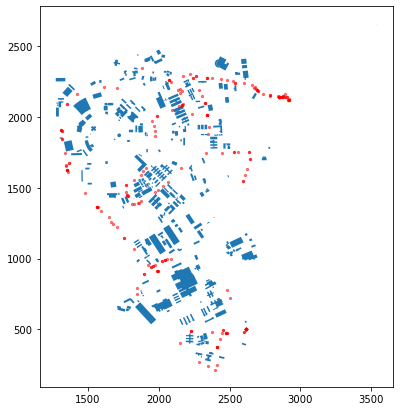

In [21]:
# visualização de pontos normalizados

ax = mapa_normalizado['geometry'].plot(figsize=(15, 7))

# pontos_rssi_norm_df.plot(ax =ax, color= 'red', alpha=0.5, linewidth=0.5, edgecolor='k')
pontos_rssi_norm_df.plot(ax =ax, color= 'red', alpha=0.5, linewidth=1, markersize =5)

In [ ]:
pontos_rssi_norm_df.head()

In [22]:
# Criar csv

colunms_names  = ['rssi', 'x', 'y', 'z']

nodes_pos = []
for i in range(len(pontos_rssi_norm_df.geometry)):
    # tratando a string Point
    point_str = str(pontos_rssi_norm_df['geometry'][i])
    point_coords = point_str[point_str.find("(") + 1:]
    point_coords = point_coords[ : point_coords.find(")")]
    x = point_coords.split()[0]
    y = point_coords.split()[1]
    z = 1.5

    items_per_row = [
        pontos_rssi_norm_df.loc[i]['rssi'],
        x,
        y,
        z
    ]
    
    nodes_pos.append(items_per_row)

output_filename = 'rssi_pos_dataset.csv'
create_csv(output_filename, colunms_names)
add_csv_rows(nodes_pos, colunms_names, output_filename)

NameError: name 'create_csv' is not defined

In [ ]:
# visualizando dataset criado
rssi_node_pos_df = pd.read_csv('rssi_pos_dataset.csv') 

print("DATASET SHAPE:", rssi_node_pos_df.shape)
rssi_node_pos_df.head()

## Criar dataset de Mobilidade para a classe **ns3::NS2MobilityHelper** (tcl)

In [27]:
tcl_file = "mobilidade_helder_rssi.tcl"

speed    = 6.39  # m/s - velocidade yellow patinete
# speed    = 0.0  # m/s 
delta_T  = 5.0 # seg
time_sec = 0.0

with open(tcl_file, "w") as f:
    for i in range(len(pontos_rssi_norm_df.geometry)):
        # tratando a string Point
        point_str = str(pontos_rssi_norm_df['geometry'][i])
        point_coords = point_str[point_str.find("(") + 1:]
        point_coords = point_coords[ : point_coords.find(")")]
        x = point_coords.split()[0]
        y = point_coords.split()[1]
        z = str(1.5)
        
        if i == 0:
            f.write("$node_(0) set X_ " + x + "\n")
            f.write("$node_(0) set Y_ " + y + "\n")
            f.write("$node_(0) set Z_ " + z + "\n")

        time_sec = (time_sec + delta_T) if i != 0 else time_sec
        f.write("$ns_ at " + str(time_sec) + " \"$node_(0) setdest " + x + " "+ y + " " + str(speed) + "\"\n" ) 